## Importing libraries

In [ ]:
# Standard library imports
import os
import sys
import json
import random
from collections import OrderedDict

# Third-party library imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


## Save Checkpoint

In [ ]:

import os
import torch

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create a Folder in the root directory
!mkdir -p "/content/drive/My Drive/My Folder/checkpoints"

DIR_DATA = "./data"
CHECKPOINT_DIR = '/content/drive/My Drive/My Folder/checkpoints'

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def save_checkpoint(model, optimizer, epoch, hyperparameters, subfolder="", data_to_save=None):
    """Salva il checkpoint del modello e rimuove quello precedente."""
    subfolder_path = os.path.join(CHECKPOINT_DIR, subfolder)
    os.makedirs(subfolder_path, exist_ok=True)

    # File corrente e precedente
    filename = f"model_epoch_{epoch}_params_{hyperparameters}.pth"
    filepath = os.path.join(subfolder_path, filename)
    filename_json = f"model_epoch_{epoch}_params_{hyperparameters}.json"
    filepath_json = os.path.join(subfolder_path, filename_json)


    previous_filename = f"model_epoch_{epoch -1}_params_{hyperparameters}.pth"
    previous_filepath = os.path.join(subfolder_path, previous_filename)
    previous_filename_json = f"model_epoch_{epoch -1}_params_{hyperparameters}.json"
    previous_filepath_json = os.path.join(subfolder_path, previous_filename_json)

    # Rimuove il checkpoint precedente
    if epoch > 1 and os.path.exists(previous_filepath) and os.path.exists(previous_filepath_json):
        os.remove(previous_filepath)
        os.remove(previous_filepath_json)

    # Salva il nuovo checkpoint
    if optimizer is not None:
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),  # Salvataggio dello stato dell'ottimizzatore
            'epoch': epoch
        }, filepath)
    else:
        torch.save({
            'model_state_dict': model.state_dict(),
            'epoch': epoch
        }, filepath)
    print(f"Checkpoint salvato: {filepath}")

    with open(filepath_json, 'w') as json_file:
      json.dump(data_to_save, json_file, indent=4)


def load_checkpoint(model, optimizer, hyperparameters, subfolder=""):
    """Carica l'ultimo checkpoint disponibile basato sugli iperparametri."""
    subfolder_path = os.path.join(CHECKPOINT_DIR, subfolder)
    if not os.path.exists(subfolder_path):
        print("No checkpoint found, Starting now...")
        return 1, None  # Le epoche iniziano da 1

    # Cerca i file con gli iperparametri specificati
    files = [f for f in os.listdir(subfolder_path) if f"params_{hyperparameters}" in f and f.endswith('.pth')]
    if files:
        # Trova il file con l'epoca più alta
        latest_file = max(files, key=lambda x: int(x.split('_')[2]))
        filepath = os.path.join(subfolder_path, latest_file)
        checkpoint = torch.load(filepath)

        model.load_state_dict(checkpoint['model_state_dict'])
        if optimizer is not None:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        # Trova e carica il file JSON associato
        json_filename = latest_file.replace('.pth', '.json')
        json_filepath = os.path.join(subfolder_path, json_filename)
        json_data = None
        if os.path.exists(json_filepath):
            with open(json_filepath, 'r') as json_file:
                json_data = json.load(json_file)
            print(f"JSON data loaded: {json_filepath}")
        else:
            print(f"No JSON file found for: {latest_file}")

        print(f"Checkpoint found: Resume epoch {checkpoint['epoch'] + 1}")
        return checkpoint['epoch'] + 1, json_data

    print("No checkpoint found, Starting now...")
    return 1, None  # Le epoche iniziano da 1



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# CIFAR100 Dataset

In [ ]:
class CIFAR100Dataset(Dataset):
    def __init__(self, root, split='train', transform=None, sharding=None, K=10, Nc=2):
        """
        CIFAR-100 Dataset with IID and non-IID sharding.

        Args:
        - root (str): Directory to store the dataset.
        - split (str): 'train' or 'test'.
        - transform (callable): Transformations applied to the images.
        - sharding (str): 'iid' or 'niid'.
        - K (int): Number of clients for the sharding.
        - Nc (int): Number of classes per client (used for non-iid sharding).
        """
        self.root = root
        self.split = split
        self.transform = transform
        self.sharding = sharding
        self.K = K
        self.Nc = Nc

        # Default transformations if none are provided
        if self.transform is None:
            if self.split == 'train':
                self.transform = transforms.Compose([
                    transforms.RandomHorizontalFlip(),  # Flip orizzontale casuale
                    transforms.RandomRotation(10),
                    transforms.ToTensor(),  # Converte l'immagine in un tensore PyTorch
                    transforms.Normalize(mean=[0.5071, 0.4865, 0.4409], std=[0.2673, 0.2564, 0.2762]),  # Normalizzazione
                ])
            else:
                self.transform = transforms.Compose([
                    transforms.ToTensor(),  # Converte in tensore PyTorch
                    transforms.Normalize(mean=[0.5071, 0.4865, 0.4409], std=[0.2673, 0.2564, 0.2762]),  # Normalizzazione
                ])

        dataset = datasets.CIFAR100(
            root=self.root,
            train=(self.split == 'train'),
            download=True
        )

        self.data = pd.DataFrame({
            "image": [dataset[i][0] for i in range(len(dataset))],
            "label": [dataset[i][1] for i in range(len(dataset))]
        })

        if self.split == 'train' and self.sharding:
            self.data = self._apply_sharding()

    def _apply_sharding(self):
        """Apply IID or non-IID sharding to the training data."""
        if self.sharding == 'iid':
            return self._iid_sharding()
        elif self.sharding == 'niid':
            return self._non_iid_sharding()
        else:
            raise ValueError("Sharding must be 'iid' or 'niid'.")

    def _iid_sharding(self):
        """Split data IID: uniformly distribute samples across K clients."""
        data_split = []
        indices = self.data.index.tolist()
        random.shuffle(indices)

        # Split indices equally among K clients
        client_indices = [indices[i::self.K] for i in range(self.K)]

        for client_id, idxs in enumerate(client_indices):
            client_data = self.data.loc[idxs].copy()
            client_data['client_id'] = client_id
            data_split.append(client_data)

        return pd.concat(data_split, ignore_index=True)

    def _non_iid_sharding(self):
        """Split data non-IID: assign Nc classes per client."""
        data_split = []
        unique_classes = self.data['label'].unique()
        random.shuffle(unique_classes)

        # Divide classes into groups of Nc
        class_groups = [unique_classes[i:i + self.Nc] for i in range(0, len(unique_classes), self.Nc)]
        class_groups = class_groups[:self.K]  # Limit to K clients

        for client_id, class_group in enumerate(class_groups):
            client_data = self.data[self.data['label'].isin(class_group)].copy()
            client_data['client_id'] = client_id

            # Ensure approximately equal samples per client
            client_data = client_data.sample(n=len(self.data) // self.K, replace=True, random_state=42)
            data_split.append(client_data)

        return pd.concat(data_split, ignore_index=True)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        image, label = row['image'], row['label']

        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.data)


NameError: name 'Dataset' is not defined

## LeNet-5

In [ ]:
class LeNet5(nn.Module):
    def __init__(self,num_classes=100):
        super(LeNet5, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64 * 5 * 5, 384),  # Updated to be consistent with data augmentation
            nn.ReLU(),
            nn.Linear(384, 192),
            nn.ReLU(),
            nn.Linear(192, num_classes)  # 100 classes for CIFAR-100
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)  # Flatten the output of the conv layers
        x = self.fc_layer(x)
        x = F.log_softmax(x, dim=1)
        return x

# Centralized training of CIFAR100

In [ ]:
def train_model(model, train_loader, validation_loader, test_loader, optimizer, scheduler, criterion, epochs, hyperparameters):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_losses, validation_losses, validation_accuracies, test_losses, test_accuracies = [], [], [], [], []

    # Carica checkpoint se esiste
    start_epoch, json_data = load_checkpoint(model, optimizer, hyperparameters, "Centralized/")
    if json_data is not None:
        validation_losses = json_data.get('validation_losses', [])
        validation_accuracies = json_data.get('validation_accuracies', [])
        train_losses = json_data.get('train_losses', [])
        test_losses = json_data.get('test_losses', [])
        test_accuracies = json_data.get('test_accuracies', [])

    if start_epoch >= epochs:
        print(f"Checkpoint trovato, configurazione già completata. Valutazione solo sul validation set.")
        validation_loss, validation_accuracy = evaluate_model(model, validation_loader, criterion, device)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)
        return train_losses, validation_losses, validation_accuracies, test_losses, test_accuracies

    for epoch in range(start_epoch, epochs + 1):
        model.train()
        epoch_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        scheduler.step()

        # Valutazione sul validation set
        validation_loss, validation_accuracy = evaluate_model(model, validation_loader, criterion, device)
        train_losses.append(epoch_loss / len(train_loader))
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)
        test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # Salva checkpoint
        save_checkpoint(
            model, optimizer, epoch, hyperparameters, "Centralized/",
            data_to_save={
                'validation_losses': validation_losses,
                'validation_accuracies': validation_accuracies,
                'test_losses': test_losses,
                'test_accuracies': test_accuracies,
                'train_losses': train_losses
            }
        )

        print(f"Epoch {epoch}/{epochs}, Train Loss: {epoch_loss:.4f}, "
              f"Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}, "
              f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return train_losses, validation_losses, validation_accuracies, test_losses, test_accuracies


def evaluate_model(model, validation_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in validation_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    return total_loss / len(validation_loader), correct / total


In [ ]:
# Configurazione iperparametri migliori
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 0.001

train_dataset = CIFAR100Dataset(DIR_DATA, split='train')
test_dataset = CIFAR100Dataset(DIR_DATA, split='test')
train_indices, validation_indices = train_test_split(
    range(len(train_dataset)), test_size=0.2, random_state=42
)

# Crea Subset
train_dataset = Subset(train_dataset, train_indices)
validation_dataset = Subset(CIFAR100Dataset(DIR_DATA, split='train'), validation_indices)
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(validation_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Dataloader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model_cifar = LeNet5(100)
optimizer_cifar = optim.SGD(model_cifar.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler_cifar = CosineAnnealingLR(optimizer_cifar, T_max=200)
criterion = nn.CrossEntropyLoss()

# Training del modello
train_losses, validation_losses, validation_accuracies, test_losses, test_accuracies = train_model(
    model=model_cifar,
    train_loader=train_dataloader,
    validation_loader=validation_dataloader,
    test_loader=test_dataloader,
    optimizer=optimizer_cifar,
    scheduler=scheduler_cifar,
    criterion=criterion,
    epochs=EPOCHS,
    hyperparameters=f"BS{BATCH_SIZE}_LR{LEARNING_RATE}_WD{WEIGHT_DECAY}_M{MOMENTUM}"
)

# Grafici
plt.figure(figsize=(14, 10))

# Validation Loss
plt.subplot(2, 2, 1)
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss per Epoch')
plt.legend()
plt.savefig('validation_loss.png')

# Validation Accuracy
plt.subplot(2, 2, 2)
plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()
plt.savefig('validation_accuracy.png')

# Test Loss
plt.subplot(2, 2, 3)
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Loss per Epoch')
plt.legend()
plt.savefig('test_loss.png')

# Test Accuracy
plt.subplot(2, 2, 4)
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy per Epoch')
plt.legend()
plt.savefig('test_accuracy.png')

plt.tight_layout()
plt.show()

Files already downloaded and verified


KeyboardInterrupt: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## FL Baselines

In [ ]:
def generate_skewed_probabilities(num_clients, gamma):
    """It generates skewed probabilities for clients using a Dirichlet distribution."""
    probabilities = np.random.dirichlet([gamma] * num_clients)
    return probabilities

def plot_selected_clients_distribution(selected_clients_per_round, num_clients, hyperparameters):
    """Plotta la distribuzione dei client selezionati alla fine del processo."""
    counts = np.zeros(num_clients)

    # Conta quante volte ogni client è stato selezionato in tutti i round
    for selected_clients in selected_clients_per_round:
        for client in selected_clients:
            counts[client] += 1

    plt.figure(figsize=(10, 6))
    plt.bar(range(num_clients), counts, color='skyblue', edgecolor='black')
    plt.title("Distribuzione dei Client Selezionati Durante il Federated Averaging")
    plt.xlabel("Client ID")
    plt.ylabel("Frequenza di Selezione")
    plt.grid(axis='y')
    plt.savefig(f"CIFAR100_Client_distribution_{hyperparameters}.png")
    plt.show()


class Client:

  def __init__(self, model, client_id, data, optimizer_params):
    self.client_id = client_id
    self.data = data
    self.model = model
    self.optimizer_params = optimizer_params

  def train(self, global_weights, local_steps, batch_size):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.model.to(device)
    self.model.load_state_dict(global_weights)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        self.model.parameters(),
        lr=self.optimizer_params['lr'],
        momentum=self.optimizer_params['momentum'],
        weight_decay=self.optimizer_params['weight_decay']
        )
    trainloader = DataLoader(self.data, batch_size=batch_size, shuffle=True,  pin_memory=True)

    steps = 0
    while steps < local_steps:
      for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = self.model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        steps += 1
        if steps >= local_steps:
          break
    return self.model.state_dict()




In [ ]:
class Server:

  def __init__(self, model, clients, test_data):
    self.model = model
    self.clients = clients
    self.test_data = test_data
    self.round_losses = []
    self.round_accuracies = []
    self.selected_clients_per_round = [] #clint selezionati per skewness

  def federated_averaging(self, local_steps, batch_size, num_rounds, fraction_fit, skewness = None, hyperparameters = None):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.model.to(device)
     # Carica il checkpoint se esiste
    data_to_load = None
    if skewness is  None:
      start_epoch, data_to_load = load_checkpoint(self.model,optimizer=None,hyperparameters=hyperparameters, subfolder="Federated_Uniform/")
    else:
      start_epoch, data_to_load = load_checkpoint(self.model,optimizer=None,hyperparameters=hyperparameters, subfolder="Federated_Skewed/")

    if data_to_load is not None:
      self.round_losses = data_to_load['round_losses']
      self.round_accuracies = data_to_load['round_accuracies']
      self.selected_clients_per_round = data_to_load['selected_clients_per_round']


    for round in range(start_epoch, num_rounds+1):

      if skewness is not None:
        probabilities = generate_skewed_probabilities(len(self.clients), skewness)
        selected_clients = np.random.choice(self.clients, size=max(1, int(fraction_fit*len(self.clients))), replace=False, p=probabilities)

      else:
        selected_clients = np.random.choice(self.clients, size=max(1, int(fraction_fit*len(self.clients))), replace=False)

      self.selected_clients_per_round.append([client.client_id for client in selected_clients])


      global_weights = self.model.state_dict()

      # Simulating parallel clients training
      client_weights = {}
      for client in selected_clients:
        client_weights[client.client_id] = client.train(global_weights, local_steps, batch_size)

      new_global_weights = {key: torch.zeros_like(value).type(torch.float32) for key, value in global_weights.items()}

      total_data_size = sum([len(client.data) for client in selected_clients])
      for client in selected_clients:
        scaling_factor = len(client.data) / total_data_size
        for key in new_global_weights.keys():
          new_global_weights[key] += scaling_factor * client_weights[client.client_id][key]

      # Update global model weights
      self.model.load_state_dict(new_global_weights)

      # Evaluate global model every 10 rounds
      if round % 10 == 0:
        loss, accuracy = evaluate_model(self.model, DataLoader(self.test_data, batch_size=batch_size, shuffle=True, pin_memory=True), nn.CrossEntropyLoss(), device)
        self.round_losses.append(loss)
        self.round_accuracies.append(accuracy)
        print(f"Round {round}/{num_rounds} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

        data_to_save = {
          'round_losses': self.round_losses,
          'round_accuracies': self.round_accuracies,
          'selected_clients_per_round': [[client for client in round_clients] for round_clients in self.selected_clients_per_round]  # Serializziamo solo i client_id
      }

        if skewness is  None:
          save_checkpoint(self.model, None, round , hyperparameters, "Federated_Uniform/", data_to_save)
        else:
          save_checkpoint(self.model, None, round , hyperparameters, "Federated_Skewed/", data_to_save)




    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(self.round_losses, label='CIFAR-100 Test Loss')
    plt.xlabel('Round (x10)')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(self.round_accuracies, label='CIFAR-100 Test Accuracy')
    plt.xlabel('Round (x10)')
    plt.ylabel('Accuracy')
    plt.legend()
    if skewness is  None:
      plt.savefig(f"CIFAR100_fedavg_uniform{hyperparameters}.jpg")
    else:
      plt.savefig(f"CIFAR100_fedavg_skew{hyperparameters}.jpg")

    plt.show()

    plot_selected_clients_distribution(self.selected_clients_per_round, len(self.clients), hyperparameters)




100%|██████████| 169M/169M [00:04<00:00, 35.1MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
No checkpoint found, Starting now...
Round 10/2000 - Loss: 4.5797, Accuracy: 0.0222
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoints/Federated_Uniform/model_epoch_10_params_BS64_LR0.005_M0.9_WD0.004_J4_C0.1.pth
Round 20/2000 - Loss: 4.3400, Accuracy: 0.0547
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoints/Federated_Uniform/model_epoch_20_params_BS64_LR0.005_M0.9_WD0.004_J4_C0.1.pth
Round 30/2000 - Loss: 4.0551, Accuracy: 0.0815
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoints/Federated_Uniform/model_epoch_30_params_BS64_LR0.005_M0.9_WD0.004_J4_C0.1.pth
Round 40/2000 - Loss: 3.9602, Accuracy: 0.0912
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoints/Federated_Uniform/model_epoch_40_params_BS64_LR0.005_M0.9_WD0.004_J4_C0.1.pth
Round 50/2000 - Loss: 3.8791, Accuracy: 0.1062
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoi

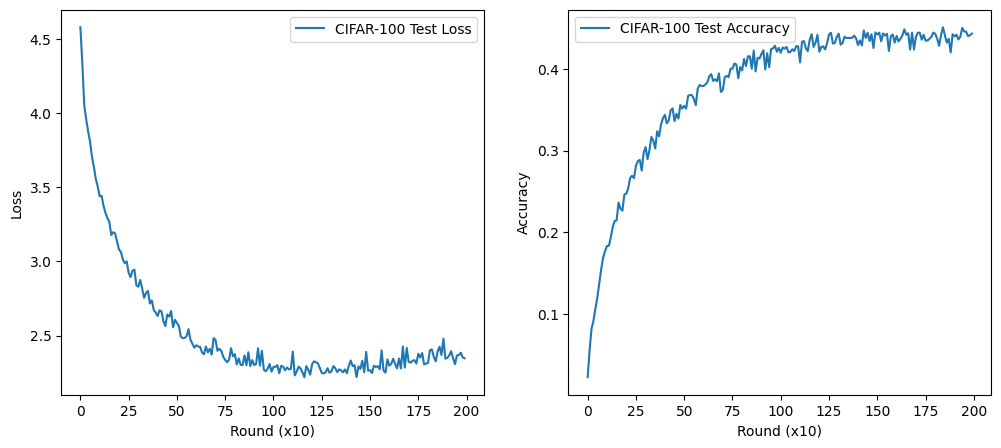

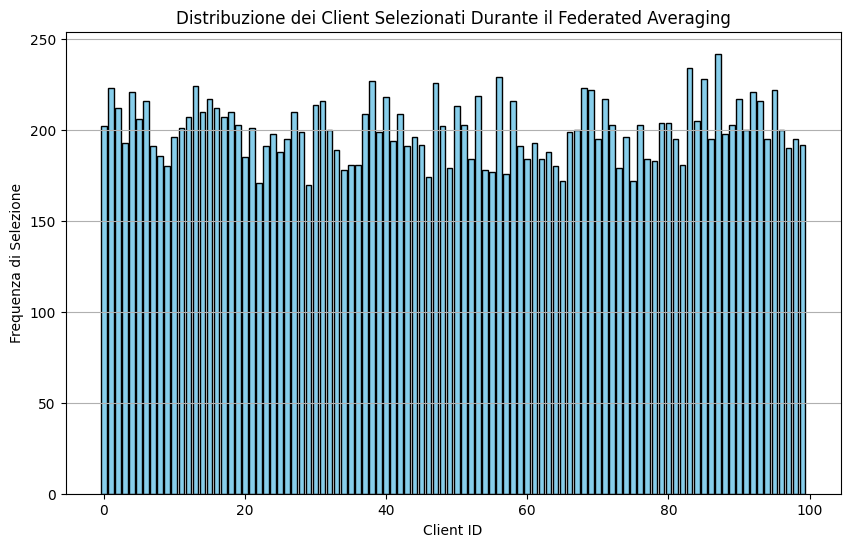

In [ ]:
K = 100 #fix
LOCAL_STEPS = 4 # J
ROUNDS = 2000
C = 0.1 #fix
BATCH_SIZE = 64
LR = 0.005
MOMENTUM = 0.9
WEIGHT_DECAY = 4e-3
SKEWNESS=0.01

optimizer_params = {
    "lr": LR,
    "momentum": MOMENTUM,
    "weight_decay": WEIGHT_DECAY
}

model_cifar = LeNet5(100)

train_dataset = CIFAR100Dataset(DIR_DATA, split='train', sharding='iid', K=K)
test_dataset = CIFAR100Dataset(DIR_DATA, split='test')

clients = []
for i in range(K):
  client_data = Subset(train_dataset, train_dataset.data[train_dataset.data["client_id"] == i].index)
  clients.append(Client(model_cifar, i, client_data, optimizer_params))


server_uniform = Server(model_cifar, clients, test_dataset)
hyperparameters = f"BS{BATCH_SIZE}_LR{LR}_M{MOMENTUM}_WD{WEIGHT_DECAY}_J{LOCAL_STEPS}_C{C}"
server_uniform.federated_averaging(local_steps=LOCAL_STEPS, batch_size=BATCH_SIZE, num_rounds=ROUNDS, fraction_fit=C,hyperparameters=hyperparameters)



#server_skewed = Server(model_cifar, clients, test_dataset)
#hyperparameters = f"BS{BATCH_SIZE}_LR{LR}_M{MOMENTUM}_WD{WEIGHT_DECAY}_J{LOCAL_STEPS}_C{C}_SK{SKEWNESS}"
#server_skewed.federated_averaging(local_steps=LOCAL_STEPS, batch_size=BATCH_SIZE, num_rounds=ROUNDS, fraction_fit=C, skewness=SKEWNESS, hyperparameters=hyperparameters)
